<a href="https://colab.research.google.com/github/hdighidy/hello-world/blob/master/Marlaria_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds

In [2]:
from tensorflow import keras
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Flatten
from tensorflow.keras.metrics import MeanSquaredError
from tensorflow.keras.layers import Conv2D, MaxPool2D, Dense, Flatten, InputLayer, BatchNormalization
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.metrics import Accuracy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator


In [3]:
dataset, dataset_info = tfds.load(
    'malaria',
    as_supervised=True,
    with_info=True,
    shuffle_files=True,
    split=['train']
)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/1 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/27558 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/malaria/1.0.0.incomplete5NN2CU/malaria-train.tfrecord*...:   0%|          …

Dataset malaria downloaded and prepared to /root/tensorflow_datasets/malaria/1.0.0. Subsequent calls will reuse this data.


In [4]:
dataset

[<_PrefetchDataset element_spec=(TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>]

In [5]:
dataset_info

tfds.core.DatasetInfo(
    name='malaria',
    full_name='malaria/1.0.0',
    description="""
    The Malaria dataset contains a total of 27,558 cell images with equal instances
    of parasitized and uninfected cells from the thin blood smear slide images of
    segmented cells.
    """,
    homepage='https://lhncbc.nlm.nih.gov/publication/pub9932',
    data_dir=PosixGPath('/tmp/tmp6ehetbr8tfds'),
    file_format=tfrecord,
    download_size=337.08 MiB,
    dataset_size=317.62 MiB,
    features=FeaturesDict({
        'image': Image(shape=(None, None, 3), dtype=uint8),
        'label': ClassLabel(shape=(), dtype=int64, num_classes=2),
    }),
    supervised_keys=('image', 'label'),
    disable_shuffling=False,
    splits={
        'train': <SplitInfo num_examples=27558, num_shards=4>,
    },
    citation="""@article{rajaraman2018pre,
      title={Pre-trained convolutional neural networks as feature extractors toward
      improved malaria parasite detection in thin blood smear images},


In [13]:
np.random.shuffle(dataset)

In [9]:
def splits(dataset, TRAIN_RATIO, VAL_RATIO, TEST_RATIO):
  dataset_size = len(dataset)
  train_dataset = dataset.take(round(int(TRAIN_RATIO * dataset_size)))
  val_test_dataset = dataset.skip(round(int(TRAIN_RATIO * dataset_size)))
  val_dataset = val_test_dataset.take(round(int(VAL_RATIO * dataset_size)))
  test_dataset = val_test_dataset.skip(round(int(VAL_RATIO * dataset_size)))
  return train_dataset, val_dataset, test_dataset

In [10]:
TRAIN_RATIO = 0.6
VAL_RATIO = 0.2
TEST_RATIO = 0.2
train_dataset, val_dataset, test_dataset = splits(dataset[0], TRAIN_RATIO, VAL_RATIO, TEST_RATIO)

In [11]:
print(len(train_dataset), 'Training Dataset')
print(len(val_dataset), 'Validation Dataset')
print(len(test_dataset), 'Testing Dataset')

16534 Training Dataset
5511 Validation Dataset
5513 Testing Dataset


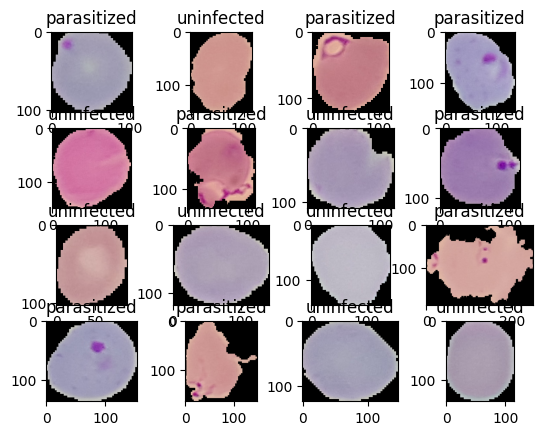

In [14]:
for i, (image,label) in enumerate(train_dataset.take(16)):
  ax = plt.subplot(4,4,i+1)
  plt.imshow(image)
  plt.title(dataset_info.features['label'].int2str(label))

In [15]:
img_size = 224
def resize_rescale(image, label):
  return tf.image.resize(image, (img_size, img_size))/255.0, label

In [16]:
train_dataset = train_dataset.map(resize_rescale)
test_dataset = test_dataset.map(resize_rescale)
val_dataset = val_dataset.map(resize_rescale)

In [17]:
train_dataset = train_dataset.shuffle(buffer_size=8, reshuffle_each_iteration=True).batch(32).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.shuffle(buffer_size=8, reshuffle_each_iteration=True).batch(32).prefetch(tf.data.AUTOTUNE)
val_dataset = val_dataset.shuffle(buffer_size=8, reshuffle_each_iteration=True).batch(32).prefetch(tf.data.AUTOTUNE)

In [18]:
train_dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>

In [19]:
val_dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>

In [20]:
test_dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>

In [21]:
model = tf.keras.Sequential([
    InputLayer(input_shape = (img_size,img_size,3)),

    Conv2D(filters=6, kernel_size=3, strides=1, padding='valid', activation='relu'),
    BatchNormalization(),
    MaxPool2D(pool_size=2, strides=2),

    Conv2D(filters=16, kernel_size=3, strides=1, padding='valid', activation='relu'),
    BatchNormalization(),
    MaxPool2D(pool_size=2, strides=2),

    Flatten(),

    Dense(100, activation='relu'),
    BatchNormalization(),

    Dense(10, activation='relu'),
    BatchNormalization(),

    Dense(1, activation='softmax'),

])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 6)       168       
                                                                 
 batch_normalization (Batch  (None, 222, 222, 6)       24        
 Normalization)                                                  
                                                                 
 max_pooling2d (MaxPooling2  (None, 111, 111, 6)       0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 16)      880       
                                                                 
 batch_normalization_1 (Bat  (None, 109, 109, 16)      64        
 chNormalization)                                                
                                                        

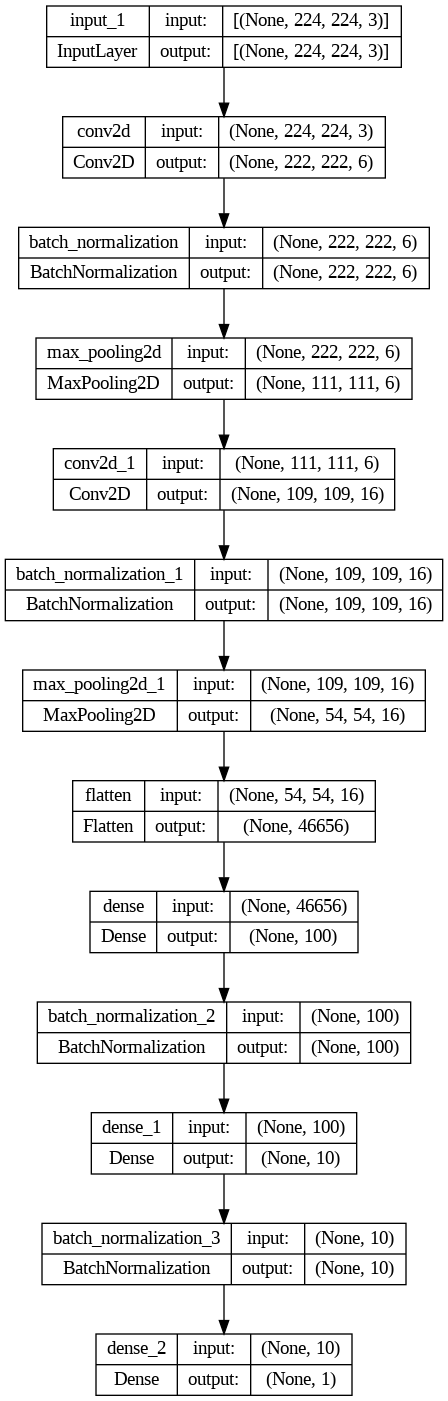

In [22]:
keras.utils.plot_model(model, "Model_malaria.png", show_shapes=True)

In [23]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=[tf.keras.metrics.BinaryAccuracy(),
                       tf.keras.metrics.FalseNegatives()])

In [24]:
history = model.fit(train_dataset, validation_data= val_dataset, batch_size=50, shuffle=True, epochs=10, verbose=1)

Epoch 1/10
517/517 [==============================] - 650s 1s/step - loss: 0.5359 - binary_accuracy: 0.4995 - false_negatives: 0.0000e+00 - val_loss: 0.6679 - val_binary_accuracy: 0.5012 - val_false_negatives: 0.0000e+00
Epoch 2/10
517/517 [==============================] - 642s 1s/step - loss: 0.2799 - binary_accuracy: 0.4996 - false_negatives: 0.0000e+00 - val_loss: 0.3106 - val_binary_accuracy: 0.5012 - val_false_negatives: 0.0000e+00
Epoch 3/10
517/517 [==============================] - 657s 1s/step - loss: 0.2134 - binary_accuracy: 0.4997 - false_negatives: 0.0000e+00 - val_loss: 0.2254 - val_binary_accuracy: 0.5015 - val_false_negatives: 0.0000e+00
Epoch 4/10
517/517 [==============================] - 638s 1s/step - loss: 0.1695 - binary_accuracy: 0.4996 - false_negatives: 0.0000e+00 - val_loss: 0.2957 - val_binary_accuracy: 0.5023 - val_false_negatives: 0.0000e+00
Epoch 5/10
517/517 [==============================] - 653s 1s/step - loss: 0.1811 - binary_accuracy: 0.4996 - false_

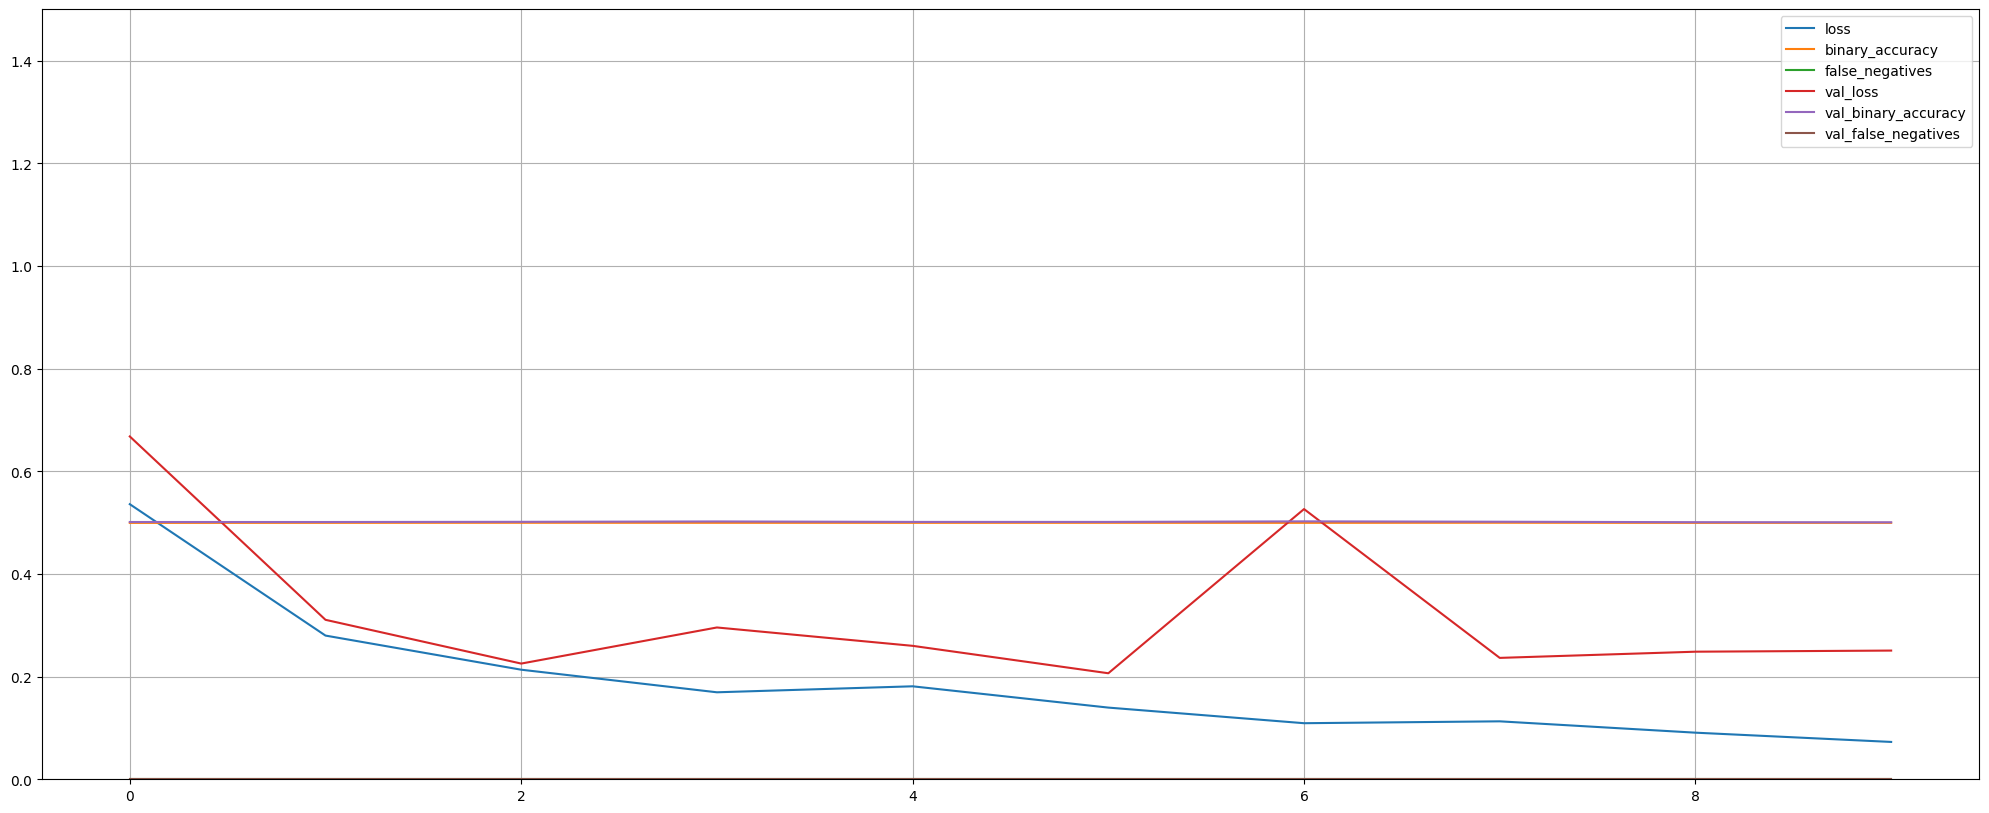

In [26]:
import pandas as pd
pd.DataFrame(history.history).plot(figsize=(25, 10))
plt.grid(True)
plt.gca().set_ylim(0, 1.5)
plt.show()

In [25]:
model.evaluate(test_dataset)

173/173 [==============================] - 73s 347ms/step - loss: 0.2927 - binary_accuracy: 0.4994 - false_negatives: 0.0000e+00


[0.29266712069511414, 0.4993651509284973, 0.0]

Text(0.5, 1.0, 'Training and validation loss')

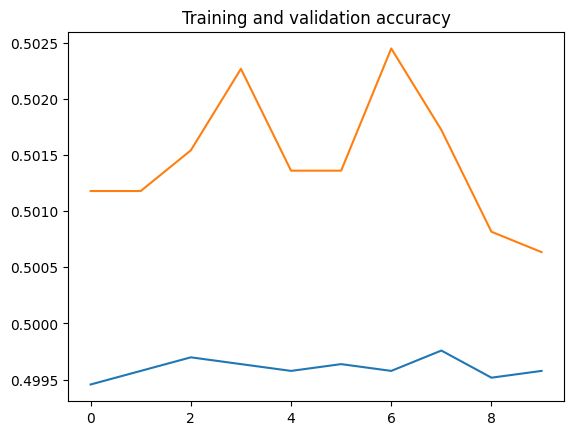

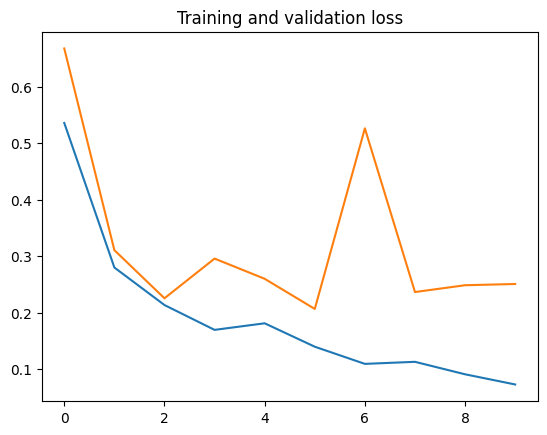

In [28]:
#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
acc      = history.history['binary_accuracy']
val_acc  = history.history['val_binary_accuracy']
loss     = history.history['loss']
val_loss = history.history['val_loss']

epochs   = range(len(acc)) # Get number of epochs

#------------------------------------------------
# Plot training and validation accuracy per epoch
#------------------------------------------------
plt.plot  ( epochs,     acc )
plt.plot  ( epochs, val_acc )
plt.title ('Training and validation accuracy')
plt.figure()

#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot  ( epochs,     loss )
plt.plot  ( epochs, val_loss )
plt.title ('Training and validation loss'   )